# Data preparation
Takes the videos, both annotated and original ones and takes each frame apart for learning on individual images.

In [1]:
!git clone -b network_search --single-branch https://github.com/DeepTesla/deep_learning_hf dl
%cd dl

Cloning into 'dl'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 126 (delta 6), reused 11 (delta 6), pack-reused 114
Receiving objects: 100% (126/126), 718.38 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Checking out files: 100% (53/53), done.
/content/dl


In [2]:
# import required libraries
import cv2
import os
import glob
import logging
import concurrent.futures
import numpy as np
import keras

# Set random seeds
np.random.seed(2019)
from tensorflow import set_random_seed
set_random_seed(1118)

keras.__version__

Using TensorFlow backend.


'2.2.5'

The below code iterates through all the videos in a directory and cuts them into single images. To fasten up this process multithreading was applied.

In [3]:
logging.basicConfig(level=logging.INFO, format='[%(levelname)s]: %(message)s')

train_dir = os.path.join(os.getcwd(), 'data', "train")
valid_dir = os.path.join(os.getcwd(), 'data', "validation")
test_dir = os.path.join(os.getcwd(), 'data', "test")
dirs = [train_dir, valid_dir, test_dir]

new_res = (256, 192)

def video2images(directory):
    logging.info(f"Managing directory: {directory}")

    # Get the list of available recordings
    annot_vids = sorted(glob.glob(os.path.join(directory, '*_annot_pp.avi')))
    orig_vids = sorted(glob.glob(os.path.join(directory, '*_orig_pp.avi')))

    # Check whether original and annotated recordings number match or not
    assert len(annot_vids) == len(orig_vids)
    
    logging.info(f"{directory} Number of files found: {len(annot_vids)}. Taking apart video files...")

    os.makedirs(os.path.join(directory, 'orig'))
    os.makedirs(os.path.join(directory, 'annot'))

    img_counter = 0
    vid_counter = 0
    # Iterate and postprocess every recording
    for vid_a, vid_o in zip(annot_vids, orig_vids):

        # Open recordings...
        cap_orig = cv2.VideoCapture(vid_o)
        cap_annot = cv2.VideoCapture(vid_a)
        if not cap_orig.isOpened() or not cap_annot.isOpened():
            logging.warning(f"{directory} Could not open file nr. {vid_counter}! Continuing...", )
            continue
        
        # Check whether recordings hold the same number of frames
        if cap_orig.get(cv2.CAP_PROP_FRAME_COUNT) != cap_annot.get(cv2.CAP_PROP_FRAME_COUNT):
            logging.warning(f"{directory} Different video length encountered in video nr. {vid_counter}! Continuing...")
            continue
        
        
        # Produce output videos
        logging.debug(f"{directory} Processing recording nr. {vid_counter}...")
        while cap_orig.isOpened() and cap_annot.isOpened(): # Iterate through every frame
            ret_o, frame_o = cap_orig.read()
            ret_a, frame_a = cap_annot.read()
            if not ret_o or not ret_a:
                break

            frame_o = cv2.resize(frame_o, new_res)
            frame_a = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)
            frame_a = cv2.resize(frame_a, new_res)

            filename = str(img_counter).zfill(6) + '.png'
            filepath_o = os.path.join(directory, 'orig', filename)
            filepath_a = os.path.join(directory, 'annot', filename)
            # Save both frames in new file
            cv2.imwrite(filepath_o, frame_o)
            cv2.imwrite(filepath_a, frame_a)

            img_counter += 1

        
        logging.debug(f"{directory} Processing of recording nr. {vid_counter} done.")
        vid_counter += 1
        
        # Release VideoCapture resources
        cap_orig.release()
        cap_annot.release()

        os.remove(vid_a)
        os.remove(vid_o)

    logging.info(f"{directory} Video files taken apart! Images generated: {img_counter}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures_of_images = [executor.submit(video2images, directory) for directory in dirs]
    
    concurrent.futures.wait(futures_of_images)

[INFO]: Managing directory: /content/dl/data/train
[INFO]: Managing directory: /content/dl/data/validation
[INFO]: Managing directory: /content/dl/data/test
[INFO]: /content/dl/data/train Number of files found: 9. Taking apart video files...
[INFO]: /content/dl/data/validation Number of files found: 2. Taking apart video files...
[INFO]: /content/dl/data/test Number of files found: 3. Taking apart video files...
[INFO]: /content/dl/data/validation Video files taken apart! Images generated: 357
[INFO]: /content/dl/data/test Video files taken apart! Images generated: 568
[INFO]: /content/dl/data/train Video files taken apart! Images generated: 1388


Set variables for easier data access in later code.

In [4]:
train_x_dir = os.path.join(train_dir, 'orig')
train_y_dir = os.path.join(train_dir, 'annot')
valid_x_dir = os.path.join(valid_dir, 'orig')
valid_y_dir = os.path.join(valid_dir, 'annot')
test_x_dir = os.path.join(test_dir, 'orig')
test_y_dir = os.path.join(test_dir, 'annot')

train_cnt = len(glob.glob(os.path.join(train_x_dir, '*.png')))
valid_cnt = len(glob.glob(os.path.join(valid_x_dir, '*.png')))
test_cnt = len(glob.glob(os.path.join(test_x_dir, '*.png')))

assert train_cnt == len(glob.glob(os.path.join(train_y_dir, '*.png')))
assert valid_cnt == len(glob.glob(os.path.join(valid_y_dir, '*.png')))
assert test_cnt == len(glob.glob(os.path.join(test_y_dir, '*.png')))

print(f"Train set count: {train_cnt}")
print(f"Valid set count: {valid_cnt}")
print(f"Test set count: {test_cnt}")

Train set count: 1388
Valid set count: 357
Test set count: 568


# Model creation and training
We define custom generators to create batches of learning data. Then we will create our model and initialize all necessary callbacks for efficient learning. Then we fit our generators until stop conditions are satisfied.

In [0]:
def data_generator(batch_size, total_count, inputs_dir, outputs_dir,
                   target_use_last_dim=False):
    while True:
        # read batch size random indexed images
        t_idxs = np.random.randint(0, total_count, batch_size)
        x_shape = (batch_size, new_res[1], new_res[0], 3)
        y_shape = (batch_size, new_res[1], new_res[0])
        x = np.zeros(shape=x_shape, dtype=np.float32)
        y = np.zeros(shape=y_shape, dtype=np.float32)

        for i, idx in enumerate(t_idxs):
            filename = f'{idx:06d}.png'
            x[i] = cv2.imread(os.path.join(inputs_dir, filename))
            y[i] = cv2.imread(os.path.join(outputs_dir, filename), cv2.IMREAD_GRAYSCALE) 
            y[i][y[i] > 122] = 255
            y[i][y[i] <= 122] = 0

        if target_use_last_dim:
            y = np.expand_dims(y, axis=3)
        
        yield (x/255,y/255)

batch_size = 8
train_steps = int(train_cnt / batch_size) + 1
valid_steps = int(valid_cnt / batch_size) + 1
train_gen = data_generator(batch_size, train_cnt, train_x_dir, train_y_dir, target_use_last_dim=True)
valid_gen = data_generator(batch_size, valid_cnt, valid_x_dir, valid_y_dir, target_use_last_dim=True)
test_gen = data_generator(batch_size, test_cnt, test_x_dir, test_y_dir, target_use_last_dim=True)

Our model consists of an encoder half-network that is followed by a decoder half-network, with sigmoid activation applied to the combined output of the last decoder layer.

In [6]:
from network_utils.tiramisu import Tiramisu
from network_utils.dice_loss import dice_loss

model = Tiramisu(n_layers_per_block = [4 for _ in range(11)], growth_rate=12)

11



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [7]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3), loss=dice_loss, metrics=['acc'])
model.summary()

[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 4 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 4 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 4 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

As we see we have about 15M parameters and practically all of them are up for training. Now we should define our callbacks.

In [0]:
checkpoint_name = 'rightlane_segment.hdf5'
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,
                                                          monitor='val_loss',
                                                          verbose=1,
                                                          save_weights_only=True,
                                                          save_best_only=True)

callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10, verbose=1)

We are ready for training! We apply our generator functions to the fit_generator function of our model.

In [9]:
model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_steps,
    epochs=50,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=valid_steps,
    callbacks=[callback_checkpoint, callback_early_stopping]
)

[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/50
174/174 [==============================] - 81s 463ms/step - loss: 0.0984 - acc: 0.9187 - val_loss: 0.3418 - val_acc: 0.7342

Epoch 00001: val_loss improved from inf to 0.34177, saving model to rightlane_segment.hdf5
Epoch 2/50
174/174 [==============================] - 60s 347ms/step - loss: 0.0236 - acc: 0.9825 - val_loss: 0.3216 - val_acc: 0.7548

Epoch 00002: val_loss improved from 0.34177 to 0.32159, saving model to rightlane_segment.hdf5
Epoch 3/50
174/174 [==============================] - 61s 348ms/step - loss: 0.0153 - acc: 0.9890 - val_loss: 0.1765 - val_acc: 0.8952

Epoch 00003: val_loss improved from 0.32159 to 0.17653, saving model to rightlane_segment.hdf5
Epoch 4/50
174/174 [==============================] - 61s 348ms/step - loss: 0.0113 - acc: 0.9917 - val_loss: 0.0436 - val_acc: 0.9770

Epoch 00004: val_loss improved from 0.17653 to 0.04362, saving model to rightlane_segment.hdf5
Epoch 5/50
174/174 [==============================] - 60s 347ms/step - loss: 0.0

It looks as our model was able to learn and since we are satisfied with the resultant metrics we will reload our last checkpoint.

In [0]:
# load best model
try:
    model.load_weights(checkpoint_name)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Evaluation
We will take a couple of samples from test data and evaluate our algorithm on those unseen pictures. This will allow us to analize the generalization of our model.

In [0]:
from google.colab.patches import cv2_imshow

def predict(num):
    x, y = next(test_gen)
    x = x[:num]
    y = y[:num]
    p = [model.predict(np.expand_dims(x[i], axis=0))[0] for i in range(len(x))]
    for r in range(len(x)):
        a = np.array(x[r])*255
        b = cv2.cvtColor(y[r]*255, cv2.COLOR_GRAY2BGR)
        c = cv2.cvtColor(p[r]*255, cv2.COLOR_GRAY2BGR)
        img = np.concatenate((a, b, c), axis=1)
        cv2_imshow(img)

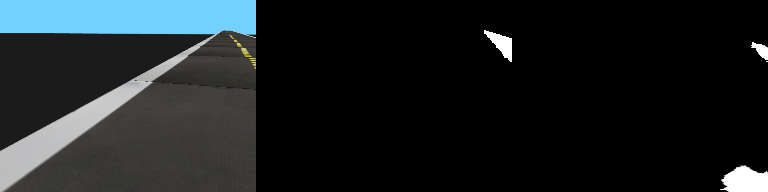

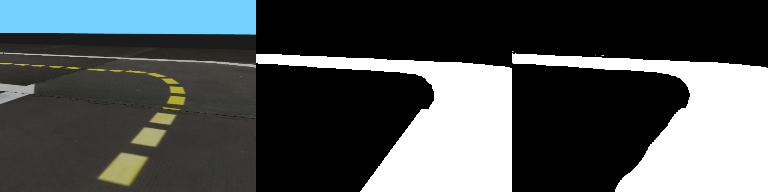

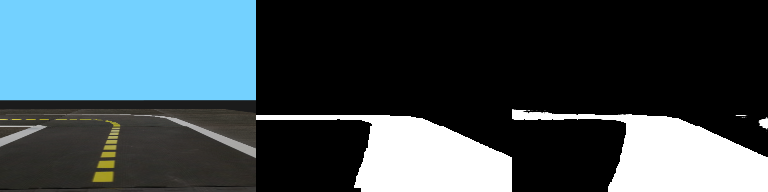

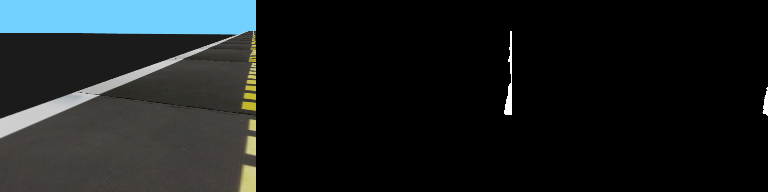

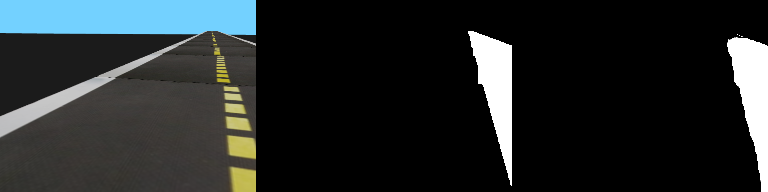

In [12]:
predict(5)

It looks as our model was able to predict quite correctly the right lane in the simulated environment. Some noises appear at some point but overall the accuracy is adequate.

Now we will measure approximate inference time on current setting.

In [13]:
import time

x, _ = next(test_gen)
x = x[:1]

diffs = [0 for _ in range(200)]
for i in range(len(diffs)):
    start = time.clock() 
    model.predict(x)
    end = time.clock()
    diffs[i] = end - start

time_for_image = sum(diffs)/len(diffs)
print(f"Time for single image: {time_for_image*1000:.3f}ms")
print(f"This translates to {1/time_for_image:.3f} fps.")

Time for single image: 22.996ms
This translates to 43.486 fps.
